In [2]:
import numpy as np

import pandas as pd
pd.set_option('display.max_colwidth', 512)

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

import pickle

import matplotlib.pyplot as plt

### clean data

In [3]:
### build juc train

features = [ 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit','identity_attack', 'insult', 'threat']

jc_df = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv")
print(f"juc_train_df:{jc_df.shape}")
jc_df = jc_df.query ("toxicity_annotator_count > 10")
print(f"juc_train_df:{jc_df.shape}")
jc_df = jc_df.reset_index(drop=True)

jc_df[["comment_text"]+features].head()

juc_train_df:(1999516, 46)
juc_train_df:(85522, 46)


,comment_text,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat
0,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925
1,Mad dog will surely put the liberals in mental hospitals. Boorah,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789
2,And Trump continues his lifelong cowardice by not making this announcement himself.\n\nWhat an awful human being .....,0.666667,0.015873,0.031746,0.000000,0.047619,0.666667,0.000000
3,"""while arresting a man for resisting arrest"".\n\nIf you cop-suckers can't see a problem with this, then go suck the barrel of a Glock.",0.815789,0.065789,0.552632,0.592105,0.000000,0.684211,0.105263
4,Tucker and Paul are both total bad ass mofo's.,0.550000,0.037500,0.337500,0.275000,0.037500,0.487500,0.000000


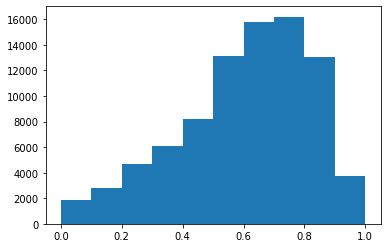

In [4]:
plt.hist(jc_df["toxicity"], bins=10)
plt.show()

In [5]:
stratified = pd.cut(jc_df["toxicity"], bins=10, labels=False)

jc_df = jc_df.rename(columns={"comment_text":"text"})    

In [6]:
N_FOLDS = 5
mkf = StratifiedKFold(n_splits=N_FOLDS, random_state=123, shuffle=True)

jc_df["kfold"] = -1
for f, (t_, v_) in enumerate(mkf.split(X=jc_df, y=stratified)):
    jc_df.loc[v_, 'kfold'] = f
    
    
jc_df.to_csv("../processed/juc.csv", index=False)
jc_df.head()

,id,text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,...,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count,kfold
0,1083994,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67,1
1,650904,Mad dog will surely put the liberals in mental hospitals. Boorah,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76,3
2,5902188,And Trump continues his lifelong cowardice by not making this announcement himself.\n\nWhat an awful human being .....,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63,0
3,7084460,"""while arresting a man for resisting arrest"".\n\nIf you cop-suckers can't see a problem with this, then go suck the barrel of a Glock.",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76,0
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80,0


### Build TF-IDF models 

In [7]:
def subsample_majority_class (df, score_column, perc = 1.5):
    min_len = (df[score_column] > 0).sum()
    df_y0_undersample = df[df[score_column] == 0].sample(n=int(min_len*perc),random_state=201)
    df = pd.concat([df[df[score_column] > 0], df_y0_undersample])
                                                
    return df


def cv_tfidf_predict (model_name, df, score_column):

    pred = np.zeros ((df.shape[0]))

    for fold in range(5):
        vec = TfidfVectorizer(analyzer='char_wb', max_df=0.5, min_df=3, ngram_range=(3, 5)) 

        train = df.query ("kfold != @fold")
        
        valid = df.query ("kfold == @fold")

        X_train = vec.fit_transform(train['text'])
        y_train = train[score_column].values

        X_valid = vec.transform(valid['text'])
        y_valid = valid[score_column].values

        model = Ridge (alpha=1.0)
        model.fit(X_train, y_train)    
        pred_train = model.predict ( X_train )
        pred_valid = model.predict ( X_valid )

        pred [valid.index.values] = pred_valid
        
        
        score_train = mean_squared_error(y_train, pred_train, squared=False)
        score_valid = mean_squared_error (y_valid, pred_valid, squared=False )
        print (f"fold:{fold} rmse_train:{score_train:.5f}, rmse_valid:{score_valid:.5f}")
        pickle.dump(model, open(f"../models/{model_name}_{fold}.pkl", 'wb'))
        pickle.dump(vec, open(f"../models/{model_name}_vec_{fold}.pkl", 'wb'))
        


    y_true = df[score_column]
    score_tot = mean_squared_error ( y_true, pred, squared = False)
    print (f"tot score_tot:{score_tot:.5f}")
    return pred


def cv_tfidf_proba (model_name, df, score_column, subsample_perc = 1.5):

    pred = np.zeros ((df.shape[0]))

    for fold in range(5):
        vec = TfidfVectorizer(analyzer='char_wb', max_df=0.5, min_df=3, ngram_range=(3, 5)) 

        train = df.query ("kfold != @fold")
        
        valid = df.query ("kfold == @fold")

        train = subsample_majority_class (train, score_column,  perc = subsample_perc )

        X_train = vec.fit_transform(train['text'])
        y_train = train[score_column].values

        X_valid = vec.transform(valid['text'])
        y_valid = valid[score_column].values

        model = LogisticRegression ()
        model.fit(X_train, y_train)    
        pred_train = model.predict_proba ( X_train )[:,1]
        pred_valid = model.predict_proba ( X_valid )[:,1]

        pred [valid.index.values] = pred_valid
        
        
        auc_train = roc_auc_score(y_train, pred_train)
        auc_valid = roc_auc_score (y_valid, pred_valid )
        print (f"fold:{fold} auc_train:{auc_train:.5f}, auc_valid:{auc_valid:.5f}")
        pickle.dump(model, open(f"../models/{model_name}_{fold}.pkl", 'wb'))
        pickle.dump(vec, open(f"../models/{model_name}_vec_{fold}.pkl", 'wb'))
        


    y_true = df[score_column]
    auc_tot = roc_auc_score ( y_true, pred)
    print (f"tot auc_tot:{auc_tot:.5f}")
    return pred


def tf_idf_feature (texts, feature_name, path, predict_proba = True,  folds=5):
    pred = np.zeros( (len(texts), ) )
    for fold in range(folds):
        model = pickle.load(open(f"{path}/{feature_name}_{fold}.pkl", 'rb'))
        vec = pickle.load(open(f"{path}/{feature_name}_vec_{fold}.pkl", 'rb'))
        X = vec.transform ( texts )
        if predict_proba:
            pred += model.predict_proba ( X )[:,1]
        else:
            pred += model.predict ( X )
            
    return pred/folds


In [8]:
for feat in features:
    print(feat)
    _ = cv_tfidf_predict(model_name=f"juc_tfidf_{feat}", df=jc_df, score_column=feat )

toxicity
fold:0 rmse_train:0.13507, rmse_valid:0.16352
fold:1 rmse_train:0.13543, rmse_valid:0.16253
fold:2 rmse_train:0.13515, rmse_valid:0.16327
fold:3 rmse_train:0.13482, rmse_valid:0.16466
fold:4 rmse_train:0.13502, rmse_valid:0.16384
tot score_tot:0.16357
severe_toxicity
fold:0 rmse_train:0.02498, rmse_valid:0.03007
fold:1 rmse_train:0.02516, rmse_valid:0.02931
fold:2 rmse_train:0.02493, rmse_valid:0.03036
fold:3 rmse_train:0.02498, rmse_valid:0.03026
fold:4 rmse_train:0.02499, rmse_valid:0.03016
tot score_tot:0.03003
obscene
fold:0 rmse_train:0.08757, rmse_valid:0.10647
fold:1 rmse_train:0.08791, rmse_valid:0.10489
fold:2 rmse_train:0.08754, rmse_valid:0.10626
fold:3 rmse_train:0.08750, rmse_valid:0.10703
fold:4 rmse_train:0.08736, rmse_valid:0.10712
tot score_tot:0.10636
sexual_explicit
fold:0 rmse_train:0.05869, rmse_valid:0.06940
fold:1 rmse_train:0.05837, rmse_valid:0.07110
fold:2 rmse_train:0.05807, rmse_valid:0.07258
fold:3 rmse_train:0.05864, rmse_valid:0.06980
fold:4 rmse

### Feature Extraction (RUD, VAL)

In [9]:
%%time

rud = pd.read_csv("../processed/rud_text.csv")

texts = rud["text"].values
for feat in features:
    feat_name = f"juc_tfidf_{feat}"
    print("rud", feat_name)
    rud[feat_name] = tf_idf_feature(texts, feat_name,  predict_proba = False,  path="../models", folds=N_FOLDS)

rud.to_csv("../processed/rud_text_juc_tfidf_fe.csv", index=False)


validation_texts = pd.read_csv ("../processed/validation_texts.csv")
texts = validation_texts["text"].values
for feat in features:
    feat_name = f"juc_tfidf_{feat}"
    print("valid",feat_name)
    validation_texts[feat_name] = tf_idf_feature(texts, feat_name, predict_proba = False, path="../models", folds=N_FOLDS)

validation_texts.to_csv("../processed/valid_text_juc_tfidf_fe.csv", index=False)

rud juc_tfidf_toxicity
rud juc_tfidf_severe_toxicity
rud juc_tfidf_obscene
rud juc_tfidf_sexual_explicit
rud juc_tfidf_identity_attack
rud juc_tfidf_insult
rud juc_tfidf_threat
valid juc_tfidf_toxicity
valid juc_tfidf_severe_toxicity
valid juc_tfidf_obscene
valid juc_tfidf_sexual_explicit
valid juc_tfidf_identity_attack
valid juc_tfidf_insult
valid juc_tfidf_threat
CPU times: user 8min 45s, sys: 702 ms, total: 8min 46s
Wall time: 8min 46s
